In [8]:

seed = 42
import random
random.seed(seed)

import torch
torch.manual_seed(seed)

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
from datasets.baseprim.marked_integer_dataset import MixedSprites3Dataset

from datasets.baseprim.shape3 import Shapes3Dataset

percent = 0.5
train_dataset = MixedSprites3Dataset(dataset_size=1024 // 1, p = percent)  # create a dataset with 1024 samples
test_dataset = MixedSprites3Dataset(dataset_size=128, p = percent)  # create a dataset with 128 samples for testing

#train_dataset = Shapes3Dataset(dataset_size = 1024)
#test_dataset = Shapes3Dataset(dataset_size = 128)

corpus = [data[1]["query"] for data in train_dataset]

#from data.collect_corpus import write_vocab, load_corpus, build_vocab
#vocab = build_vocab([] + corpus)
##write_vocab(vocab)


In [9]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/prototype")
### load the meta learner from the pretrained-checkpoint
pass


11 18:11:39 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
11 18:11:39 WRN `SearchExecutor` The input domain is empty, creating an empty domain
11 18:11:39 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
11 18:11:39 WRN `SearchExecutor` The input domain is empty, creating an empty domain


# Base Knowledge Learning


11 18:11:40 Filter dataset None: #before=1024, #after=1024.
11 18:11:40 Filter dataset None: #before=128, #after=128.


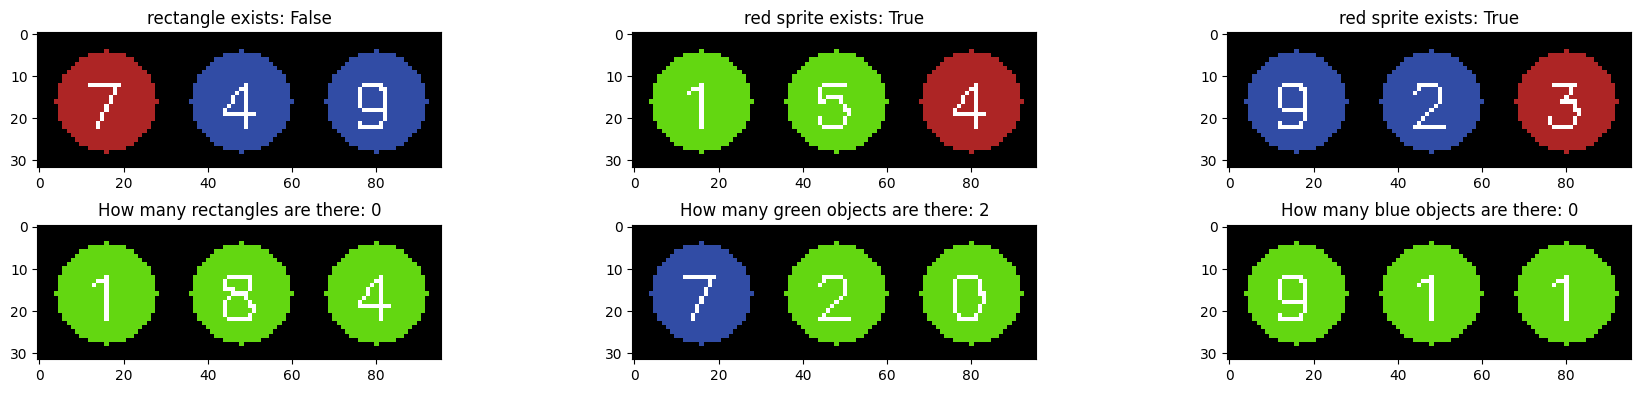

In [10]:
from core.learn import AutoLearnSchedule
from helchriss.logger import set_logger_output_file

valid_types = ["boolean", "arithmetic"]
train_logic_dataset = train_dataset.filter(lambda x : x["question_type"] in valid_types)
test_logic_dataset = test_dataset.filter(lambda x : x["question_type"] in valid_types)

# Now let's visualize a few samples from the dataset:


plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_logic_dataset[i]['image'].permute(1, 2, 0).numpy()[..., ::-1])
    plt.title(train_logic_dataset[i]['query'] + ': ' + str(train_dataset[i]['answer']))
    #stprint(train_dataset[i])
plt.tight_layout()
plt.show()



In [11]:
learner.cheat = 1
#learner.executor.supressed = 1
set_logger_output_file(f"outputs/logs/expr_{1024 // 1}.txt")
schedule = AutoLearnSchedule(train_logic_dataset, test_logic_dataset)
#schedule.procedual_train(learner, lr = 1e-3)

11 18:11:40 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
11 18:11:40 WRN `SearchExecutor` The input domain is empty, creating an empty domain
11 18:11:40 WRN `ExecutorGroup` The input domain is empty, creating an empty domain
11 18:11:40 WRN `SearchExecutor` The input domain is empty, creating an empty domain


red [0 0 1]
red count is : 1
green [1 1 0]
green count is : 2
blue [0 0 0]
blue count is : 0
circle [1 1 1]
circle count is : 3
rectangle [0 0 0]
rectangle count is : 0
triangle [0 0 0]
triangle count is : 0


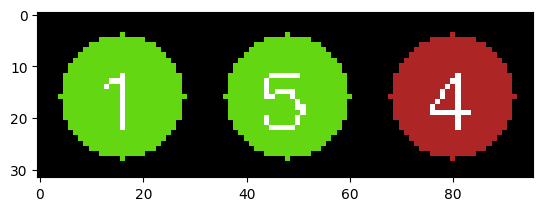

In [12]:
from core.model import MetaLearner
learner = MetaLearner([])
learner.load_ckpt("outputs/checkpoints/logic")

i = 1
img = train_logic_dataset[i]['image']
grounding = {"image": img}
plt.imshow(img.permute(1, 2, 0).numpy()[..., ::-1])

tags = ["red","green", "blue", "circle", "rectangle", "triangle"]

for tag in tags:
    program = f"filter:Logic(scene:Objects(), {tag}:Objects )"
    measure, _ = learner.executor.additive_evaluation(program, grounding)
    print(tag,(measure.value[:,0].sigmoid() + 0.5).int().detach().numpy())

    program = f"count:Logic( filter:Logic(scene:Objects(), {tag}:Objects ) )"
    measure, _ = learner.executor.additive_evaluation(program, grounding)
    print(f"{tag} count is : {int(measure.value +0.5)}")
    

In [13]:
learner.save_ckpt("outputs/checkpoints/logic") #avg_loss=3.0656, avg_acc=0.5201


0

In [14]:
tag1 = "red"
tag2 = "circle"

program = f"plus:Integer(filter:Logic(scene:Objects(), {tag1}:Objects ), filter:Logic(scene:Objects(), {tag2}:Objects ))"

from core.model import value_types, UnificationFailure

try:
    measure, _ = learner.executor.additive_evaluation(program, grounding)
except UnificationFailure as e:
    print("Unify:",e.left_structure, value_types(e.right_structure))
    learner.executor.update_chain(e.right_structure, e.left_structure)

print(tag,measure.value)

11 18:11:40 execution not found for plus:Integer([List[Embedding[object, 64]], List[Embedding[object, 64]]])
11 18:11:40 update chain : plus:Integer -> [List[Embedding[object, 64]], List[Embedding[object, 64]]]


TypeError: forward() got an unexpected keyword argument 'arg_types'

# Continual Learning Concepts
MetaLearner can continually learning new concepts using only language description of the new word and the related domain entries.

# Euclid Domain for Path and Container

In [ ]:

if __name__ == "__main__":
    from domains.math.euclid_domain import euclid_executor
    from datasets.baseprim.euclid_dataset import generate_constrained_scene

    
    # Generate constrained scene
    scene_img, scene_meta = generate_constrained_scene(euclid_executor)
    
    # Print metadata (DSL program + object specs)
    print(f"\nScene Metadata: {scene_meta['objects']}")
    
    # Save rendered scene
    import PIL.Image as Image
    img_np = (scene_img.permute(1,2,0).cpu().numpy() * 255).astype("uint8")
    Image.fromarray(img_np).save("constrained_scene_example.png")
    print("Constrained scene saved as 'constrained_scene_example.png'")

11 18:03:22 Function start automatically registered.
11 18:03:22 Function end automatically registered.
11 18:03:22 Function on_line automatically registered.
11 18:03:22 Function length automatically registered.
11 18:03:22 Function intersect automatically registered.
11 18:03:22 Function parallel automatically registered.
11 18:03:22 Function perpendicular automatically registered.
11 18:03:22 Function connect_segment automatically registered.
11 18:03:22 Function center automatically registered.
11 18:03:22 Function radius automatically registered.
11 18:03:22 Function on_radius automatically registered.
11 18:03:22 Function inside automatically registered.
11 18:03:22 Function outside automatically registered.
11 18:03:22 Function contain automatically registered.
11 18:03:22 Function intersect_line_circle automatically registered.
11 18:03:22 Function tangent automatically registered.
11 18:03:22 Function contained_line automatically registered.


Generated DSL Program: l1:line(p1,p2)[color(red)];l2:line(p2,p3)[perpendicular(l2, l1),color(green)];l3:line(p3,p4)[perpendicular(l3, l2),color(blue)] ;l4:line(p4,p1)[color(red)]

Scene Metadata: [{'name': 'l1', 'type': 'line', 'geometry': tensor([174.3484, 162.6331, 204.8672,  47.0400]), 'color_name': 'red', 'color_rgb': tensor([1., 0., 0.])}, {'name': 'l2', 'type': 'line', 'geometry': tensor([204.8672,  47.0400, 355.1316,  86.7128]), 'color_name': 'green', 'color_rgb': tensor([0., 1., 0.])}, {'name': 'l3', 'type': 'line', 'geometry': tensor([355.1316,  86.7128, 303.0558, 283.9548]), 'color_name': 'blue', 'color_rgb': tensor([0.0000, 0.1607, 1.0000])}, {'name': 'l4', 'type': 'line', 'geometry': tensor([303.0558, 283.9548, 174.3484, 162.6331]), 'color_name': 'red', 'color_rgb': tensor([1.0000, 0.5570, 0.0000])}]
Constrained scene saved as 'constrained_scene_example.png'


In [ ]:
from core.metaphors.types import find_transform_path, TransformRule, PatternVar
from helchriss.dsl.dsl_types import FLOAT, ListType, VectorType, EmbeddingType, TypeBase
from typing import Dict

if __name__ == "__main__":

        # source type : List[Vector[float, 3]]",
        initial_type = ListType(element_type=VectorType(elem_type=FLOAT, dim=3),
        )
        # target type：List[Embedding["vec3", 3]]",
        target_type = ListType(element_type=EmbeddingType(space_name="vec3", dim=3),
        )
    
        rule_pattern = ListType(
            element_type=VectorType(elem_type=PatternVar("n"), dim=PatternVar("d"))  # $d匹配任意维度\n",
        )

        def vec_to_embedding(bindings: Dict[str, TypeBase]) -> TypeBase:
            d = bindings["$d"] 
            return ListType(
                element_type=EmbeddingType(space_name="vec3", dim=d),
            )
        transform_rule = TransformRule(
            source_pattern=rule_pattern,
            transform_func=vec_to_embedding,
        )

        path = find_transform_path(
            initial_type=initial_type,
            target_type=target_type,
            rules=[transform_rule],
            max_depth=3,
        )
        if path is not None:
            print(f"Found path from {initial_type} to {target_type}"),

            for i, (rule, bindings) in enumerate(path):
                print(f"step{i+1} apply rule on the binding:"),
                for var, typ in bindings.items():
                    print(f"  {var} = {typ}"),
            print()
        else:
            print(f"cannot transform from {initial_type} to {target_type}"),



KeyError: '$d'

In [ ]:
print(isinstance(3, (float, int)))

True
